# **2. Data Preprocessing**

## Import các thư viện cần thiết

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

First of all, we will read the data in our file *lichess_games.csv* and display randomly few samples

In [2]:
lichess_games = "lichess_games.csv"
raw_df = pd.read_csv(lichess_games)
raw_df.sample(3)

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
12073,caGmLwV1,True,1.500919e+12,1.500920e+12,134,mate,black,10+0,dinobzik,1228,khaefear,1262,e4 d5 exd5 Qxd5 Nc3 Qa5 d4 Nf6 Nf3 Bg4 Bd2 e6 ...,B01,Scandinavian Defense: Main Line | Mieses Vari...,8
9388,BMR4m22D,True,1.423927e+12,1.423927e+12,10,resign,white,20+10,hassan1365416,1583,tiziocaio,1554,e4 e5 Nf3 Nf6 Nc3 c6 Bc4 h6 Nxe5 Bd6,C42,Russian Game: Three Knights Game,5
19061,orGL4RMu,False,1.504373e+12,1.504373e+12,12,outoftime,black,120+10,taranga,1277,sanchitkaushal,1047,e4 e5 Nf3 g6 Nxe5 f5 exf5 gxf5 Be2 d6 Nf3 h5,C40,King's Knight Opening,3


## A. Explore the data & Reduction Dimensionality

## How many rows and columns in our dataset?

In [3]:
row_num = raw_df.shape[0]
col_num = raw_df.shape[1]
shape = (row_num, col_num)

print(f"Number of rows and columns are: {shape}")

Number of rows and columns are: (20058, 16)


This means that there are 20058 matches in our datasets and in each match, they are totally 16 attributes

## What is the meaning of each row?

In [4]:
raw_df.sample(1)

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
14691,YVUtOAej,True,1.502395e+12,1.502395e+12,44,resign,black,8+0,rodrigowski19,1228,enviro,1060,e4 e5 Nf3 Nc6 Bc4 d6 Ng5 Qxg5 d3 Qxg2 Rf1 g6 B...,C50,Italian Game,5


Each row represents one complete game, providing details about the players, the result, the moves played, and the opening used. This allows for an analysis of individual game outcomes, player performance, and strategies.

## Are there duplicated rows?


In [5]:
raw_df["id"].value_counts().sort_values(ascending=False) 

id
XRuQPSzH    5
igSDFKv0    4
edYOVb5F    4
GstYv2mJ    4
CvakmVNb    4
           ..
ZT8bSrQX    1
Euox72jN    1
CxVMX1g4    1
zHPPTUB1    1
N8G2JHGG    1
Name: count, Length: 19113, dtype: int64

Therefore, we will delete the duplicated rows

In [6]:
raw_df.drop_duplicates("id",keep="first",inplace=True)

In [7]:
num_duplicated_rows = raw_df.duplicated().sum()
if num_duplicated_rows == 0:
    print(f"No duplicated row")
else:
    print(f"Duplicated rows: {num_duplicated_rows}")

No duplicated row


## What is the meaning of each column?

In our datasets, the meaning of each column will represent its meaning:
1. **id**: Unique identifier for the game.
2. **rated**: Whether the game is rated (TRUE or FALSE).
3. **created_at**: The timestamp when the game was created, likely in Unix time format (milliseconds).
4. **last_move_at**: The timestamp when the last move was made, also likely in Unix time format.
5. **turns**: The number of moves (turns) in the game.
6. **victory_status**: The result of the game (e.g., "outoftime", "resign", "mate" for checkmate).
7. **winner**: The player who won the game ("white" or "black").
8. **increment_code**: Time control used for the game (e.g., "15+2" means 15 minutes plus a 2-second increment per move).
9. **white_id**: The ID of the player playing white.
10. **white_rating**: The rating of the white player at the time of the game.
11. **black_id**: The ID of the player playing black.
12. **black_rating**: The rating of the black player at the time of the game.
13. **moves**: The sequence of moves played in the game.
14. **opening_eco**: The ECO (Encyclopedia of Chess Openings) code for the opening played.
15. **opening_name**: The name of the opening played.
16. **opening_ply**: The number of plies (half-moves) used in the opening phase of the game.

## What is the current data type of each column? Are there columns having inappropriate data types?

In [8]:
get_dtypes = raw_df.dtypes
get_dtypes

id                 object
rated                bool
created_at        float64
last_move_at      float64
turns               int64
victory_status     object
winner             object
increment_code     object
white_id           object
white_rating        int64
black_id           object
black_rating        int64
moves              object
opening_eco        object
opening_name       object
opening_ply         int64
dtype: object

Seems like there is no inappropriate data types in dataset features

## With numerical columns, how are values distribute ?

First of all, we will 

In [9]:
numeric_cols_df = raw_df.select_dtypes(include=['number'])

def missing_ratio(df):
    return (df.isna().mean() * 100).round(1)

def median(df):
    return (df.quantile(0.5)).round(1)

def lower_quartile(df):
    return (df.quantile(0.25)).round(1)

def upper_quartile(df):
    return (df.quantile(0.75)).round(1)

info_df = numeric_cols_df.agg([missing_ratio, "min", lower_quartile, median, upper_quartile, "max"])
info_df

,created_at,last_move_at,turns,white_rating,black_rating,opening_ply
missing_ratio,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0
min,1.376772e+12,1.376772e+12,1.0,784.0,789.0,1.0
lower_quartile,1.476910e+12,1.476912e+12,37.0,1401.0,1394.0,3.0
median,1.495670e+12,1.495670e+12,55.0,1567.0,1563.0,4.0
upper_quartile,1.503080e+12,1.503080e+12,79.0,1792.0,1785.0,6.0
max,1.504493e+12,1.504494e+12,349.0,2700.0,2723.0,28.0


C:\Users\ACER\AppData\Local\Temp\ipykernel_12484\1789459365.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(raw_df['created_at'], bins=30, ax=ax[0])
C:\Users\ACER\AppData\Local\Temp\ipykernel_12484\1789459365.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(raw_df['last_move_at'], bins=

Average Rating of White is: 1597.300005232041
Average Rating of Black is: 1590.045518756867
Average Turns is: 60.513838748495786
Average Opening Ply is: 4.815779835713912
Average created_at is: 1483413101319.3103
Average last_move_at is: 1483413974773.3328


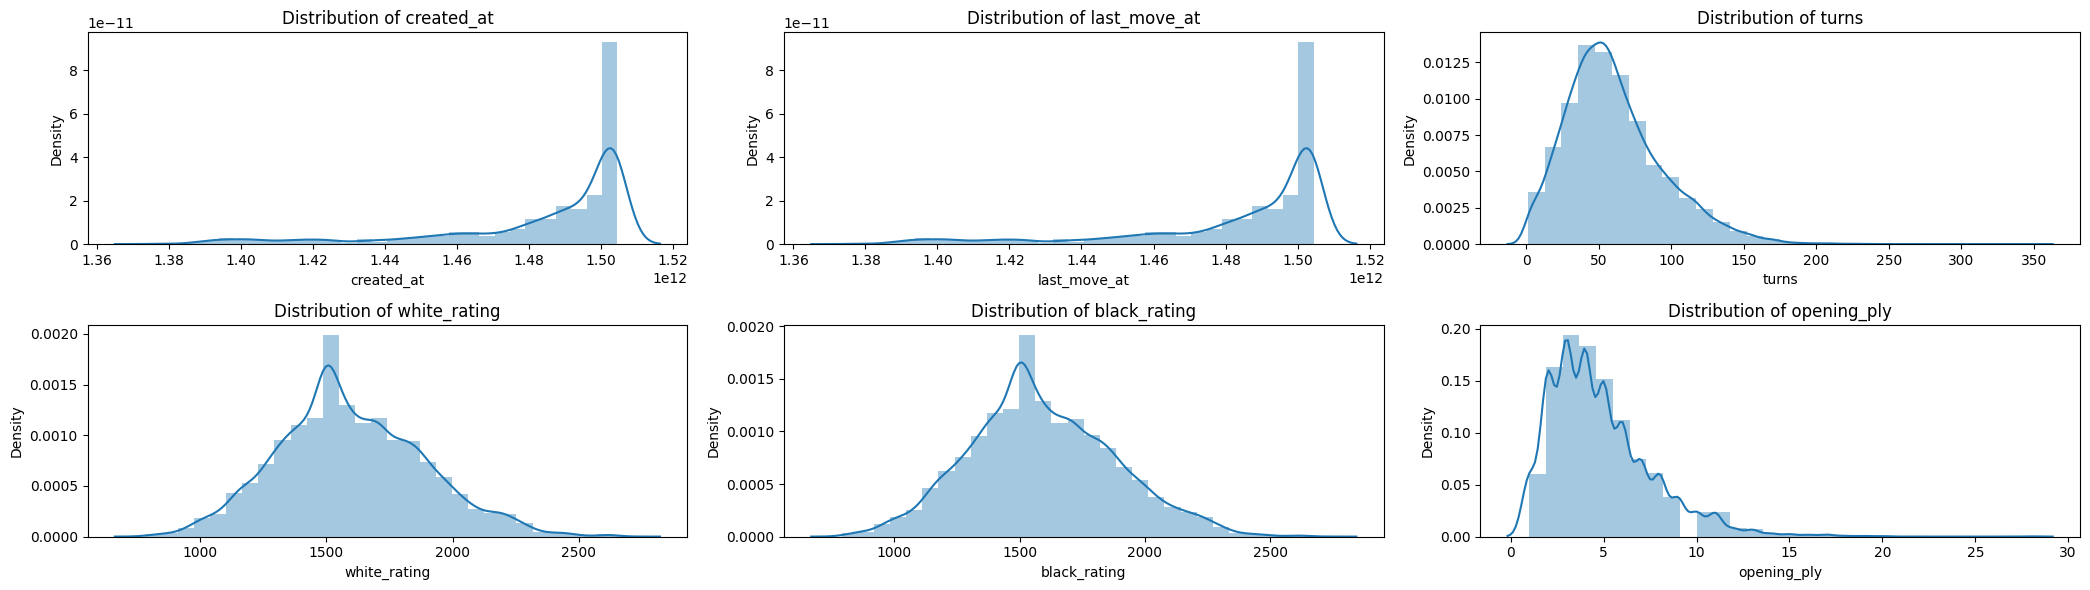

In [10]:
a4_dims = (21, 6)

# Create subplots: 2 rows, 3 columns
fig, ax = plt.subplots(2, 3, figsize=a4_dims)

# Flatten axes for easier indexing
ax = ax.flatten()

# Distribution of 'created_at'
sns.distplot(raw_df['created_at'], bins=30, ax=ax[0])
# Distribution of 'last_move_at'
sns.distplot(raw_df['last_move_at'], bins=30, ax=ax[1])
# Distribution of 'turns'
sns.distplot(raw_df['turns'], bins=30, ax=ax[2])
# Distribution of 'white_rating'
sns.distplot(raw_df['white_rating'], bins=30, ax=ax[3])
# Distribution of 'black_rating'
sns.distplot(raw_df['black_rating'], bins=30, ax=ax[4])
# Distribution of 'opening_ply'
sns.distplot(raw_df['opening_ply'], bins=30, ax=ax[5])

# Set titles for each subplot
ax[0].set(title="Distribution of created_at")
ax[1].set(title="Distribution of last_move_at")
ax[2].set(title="Distribution of turns")
ax[3].set(title="Distribution of white_rating")
ax[4].set(title="Distribution of black_rating")
ax[5].set(title="Distribution of opening_ply")

# Print average values
print('Average Rating of White is:', raw_df['white_rating'].mean())
print('Average Rating of Black is:', raw_df['black_rating'].mean())
print('Average Turns is:', raw_df['turns'].mean())
print('Average Opening Ply is:', raw_df['opening_ply'].mean())
print('Average created_at is:', raw_df['created_at'].mean())
print('Average last_move_at is:', raw_df['last_move_at'].mean())

# Adjust layout to avoid overlapping
plt.tight_layout()

# Show the plot
plt.show()

As can be shown from the charts, the value of create_at and last_move_at is abnormal since they are too the same. 
Moreovers, the meaning of create_at is redundant
So, we will delete these 2 columns

In [11]:
raw_df.drop(["created_at","last_move_at"],axis=1,inplace=True) 


In [12]:
raw_df.sample(1)

,id,rated,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
7216,1yBbX7LY,True,45,resign,white,10+0,abirray,1495,chez91,1509,e4 d5 exd5 Qxd5 Nc3 Qa5 Nf3 Bg4 h3 Bxf3 Qxf3 c...,B01,Scandinavian Defense: Main Line,6


## With each categorical column, how are values distributed?

In [13]:
def value_ratios(s):
    total_count = s.notna().sum()
    ratios = (s.value_counts(dropna=True) / total_count * 100).round(1)
    return ratios.to_dict()

def num_values(s):
    return s.value_counts().count()

object_cols = raw_df.select_dtypes(include='object')
object_cols = object_cols.agg([missing_ratio, num_values, value_ratios])
object_cols

,id,victory_status,winner,increment_code,white_id,black_id,moves,opening_eco,opening_name
missing_ratio,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
num_values,19113,4,3,400,9438,9331,18920,365,1477
value_ratios,"{'TZJHLljE': 0.0, 'ojkMBE49': 0.0, 'JTfFY9HD':...","{'resign': 56.0, 'mate': 31.3, 'outoftime': 8....","{'white': 49.9, 'black': 45.4, 'draw': 4.6}","{'10+0': 38.5, '15+0': 6.6, '15+15': 4.3, '5+5...","{'ssf7': 0.3, 'bleda': 0.3, 'hassan1365416': 0...","{'docboss': 0.2, 'cape217': 0.2, 'amanan': 0.2...","{'e4 e5': 0.1, 'e4 d5': 0.1, 'd4 d5': 0.1, 'e4...","{'A00': 5.0, 'C00': 4.2, 'D00': 3.7, 'B01': 3....","{'Sicilian Defense': 1.8, 'Van't Kruijs Openin..."


We can observe that the **id**, **move** columns is redundant because it does not have much meaning. We will remove it

In [14]:
raw_df.drop(["id","moves"],axis=1,inplace=True) 

In [15]:
raw_df

,rated,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,opening_eco,opening_name,opening_ply
0,False,13,outoftime,white,15+2,bourgris,1500,a-00,1191,D10,Slav Defense: Exchange Variation,5
1,True,16,resign,black,5+10,a-00,1322,skinnerua,1261,B00,Nimzowitsch Defense: Kennedy Variation,4
2,True,61,mate,white,5+10,ischia,1496,a-00,1500,C20,King's Pawn Game: Leonardis Variation,3
3,True,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,D02,Queen's Pawn Game: Zukertort Variation,3
4,True,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,C41,Philidor Defense,5
...,...,...,...,...,...,...,...,...,...,...,...,...
20053,True,24,resign,white,10+10,belcolt,1691,jamboger,1220,A80,Dutch Defense,2
20054,True,82,mate,black,10+0,jamboger,1233,farrukhasomiddinov,1196,A41,Queen's Pawn,2
20055,True,35,mate,white,10+0,jamboger,1219,schaaksmurf3,1286,D00,Queen's Pawn Game: Mason Attack,3
20056,True,109,resign,white,10+0,marcodisogno,1360,jamboger,1227,B07,Pirc Defense,4


### Distribution of the victory status:

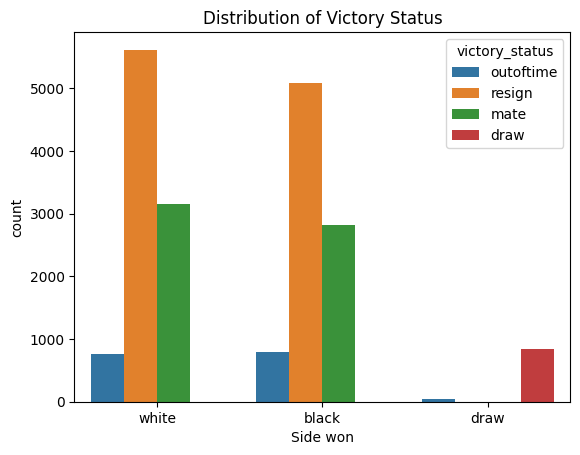

In [16]:
ax = sns.countplot( x = 'winner', hue = 'victory_status', data = raw_df)
ax_attr = ax.set(xlabel = 'Side won', title = 'Distribution of Victory Status')

### Distribution of the openings played:


C:\Users\ACER\AppData\Local\Temp\ipykernel_12484\244400024.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_attr = chart.set_xticklabels(chart.get_xticklabels(), rotation=90)


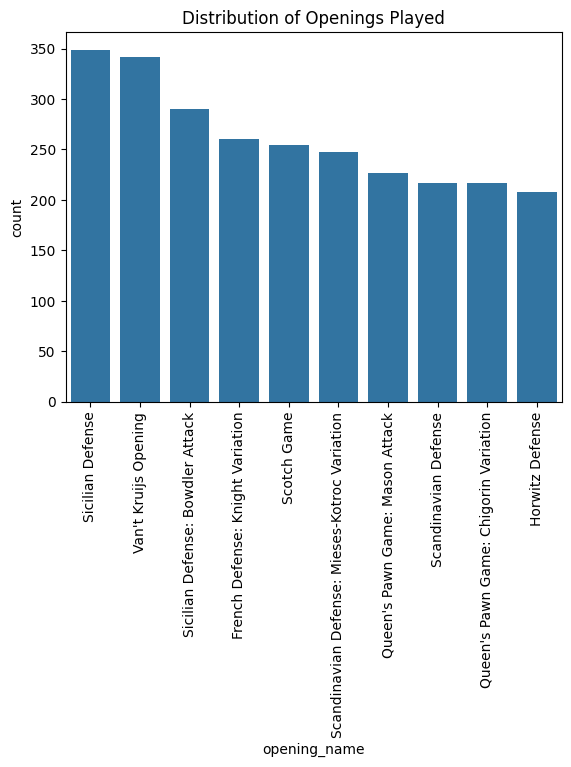

In [17]:
opening_dist = raw_df['opening_name'].value_counts()

#plotting the top 30 opening played
#opening_dist[:30].plot.bar()

#sns.countplot(games['opening_name'])
chart = sns.barplot( x = opening_dist.index[:10], y = opening_dist[:10])
ax_attr = chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
ax_attr = chart.set(title = "Distribution of Openings Played")

### Distribution of the opening_eco:

opening_eco
A00    948
C00    810
D00    701
B01    688
C41    650
      ... 
C32      1
A67      1
E18      1
D95      1
D19      1
Name: count, Length: 365, dtype: int64


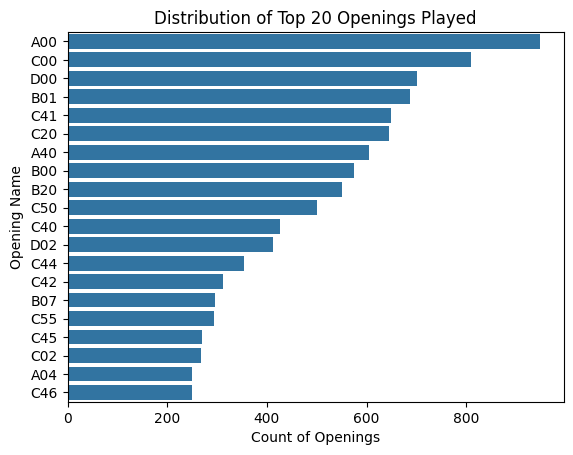

In [18]:
opening_dist = raw_df['opening_eco'].value_counts()
print(opening_dist)
# Create a horizontal bar chart (y-bar chart)
chart = sns.barplot(y=opening_dist.index[:20], x=opening_dist[:20])

# Set chart labels and title
ax_attr = chart.set_xlabel('Count of Openings')
ax_attr = chart.set_ylabel('Opening Name')
ax_attr = chart.set(title="Distribution of Top 20 Openings Played")

## Data Reduction & Intergration

In this part, we will dive into our data. To further dig deeper in this analysis, we will create more features and informations based on existing columns

The **game_category** feature is simplified into three categories: rapid, bullet, and blitz, based on the increment_code. This reduces complexity while making the data easier to analyze.

In [19]:
raw_df['game_category'] = raw_df['increment_code'].str.split('+').str[0]

raw_df['game_category'] = raw_df['game_category'].astype(int)

#This approach is more like a short-cut and not a very generalized approach. This will be fixed soon.
raw_df['game_category'][raw_df['game_category'] >= 10] = 11
raw_df['game_category'][raw_df['game_category'] < 3] = 2
raw_df['game_category'][(raw_df['game_category'] >= 3) & (raw_df['game_category'] < 10)] = 5

raw_df['game_category'].replace(11, 'rapid', inplace = True)
raw_df['game_category'].replace(2, 'bullet', inplace = True)
raw_df['game_category'].replace(5, 'blitz', inplace = True)

C:\Users\ACER\AppData\Local\Temp\ipykernel_12484\1151165773.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  raw_df['game_category'][raw_df['game_category'] >= 10] = 11
C:\Users\ACER\AppData\Local\Temp\ipykernel_12484\1151165773.py:6: Set

In [20]:
raw_df

,rated,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,opening_eco,opening_name,opening_ply,game_category
0,False,13,outoftime,white,15+2,bourgris,1500,a-00,1191,D10,Slav Defense: Exchange Variation,5,rapid
1,True,16,resign,black,5+10,a-00,1322,skinnerua,1261,B00,Nimzowitsch Defense: Kennedy Variation,4,blitz
2,True,61,mate,white,5+10,ischia,1496,a-00,1500,C20,King's Pawn Game: Leonardis Variation,3,blitz
3,True,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,D02,Queen's Pawn Game: Zukertort Variation,3,rapid
4,True,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,C41,Philidor Defense,5,rapid
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20053,True,24,resign,white,10+10,belcolt,1691,jamboger,1220,A80,Dutch Defense,2,rapid
20054,True,82,mate,black,10+0,jamboger,1233,farrukhasomiddinov,1196,A41,Queen's Pawn,2,rapid
20055,True,35,mate,white,10+0,jamboger,1219,schaaksmurf3,1286,D00,Queen's Pawn Game: Mason Attack,3,rapid
20056,True,109,resign,white,10+0,marcodisogno,1360,jamboger,1227,B07,Pirc Defense,4,rapid


How are the values in **game_category** distributed ?

In [21]:
raw_df['game_category'].value_counts()

game_category
rapid     15213
blitz      3777
bullet      123
Name: count, dtype: int64

C:\Users\ACER\AppData\Local\Temp\ipykernel_12484\652619348.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_attr = chart.set_xticklabels(chart.get_xticklabels(), rotation=90)


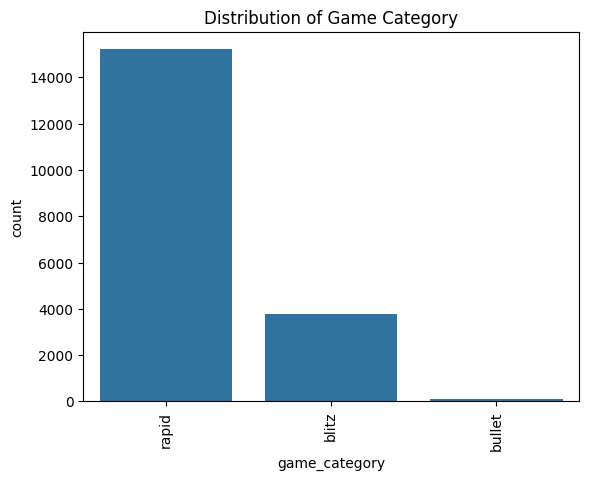

In [26]:
game_cat = raw_df['game_category'].value_counts()

#plotting the top 30 opening played
#opening_dist[:30].plot.bar()

#sns.countplot(games['opening_name'])
chart = sns.barplot( x = game_cat.index[:10], y = game_cat[:10])
ax_attr = chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
ax_attr = chart.set(title = "Distribution of Game Category")

In [22]:
raw_df['game_category'].unique()

array(['rapid', 'blitz', 'bullet'], dtype=object)

In [23]:
rating_levels = []

def assign_level(player_rating):
    level = ""
    if player_rating <= 1100:
        level = "Rookie"
    elif 1100 < player_rating <= 1600:
        level = "Beginner"
    elif 1600 < player_rating <= 2000:
        level = "Intermediate"
    elif 2000 < player_rating <= 2300:
        level = "Advanced"
    elif 2300 < player_rating <= 3000:
        level = "Expert"
    elif player_rating > 3000:
        level = "GrandMaster"
    
    rating_levels.append(level)


In [24]:
raw_df["white_rating"].map(assign_level) # use map for interact  values
raw_df["white level"]=rating_levels

rating_levels=[]    # recreate this list beacuse we will use it for blacks

raw_df["black_rating"].map(assign_level)
raw_df["black level"]= rating_levels

In [25]:
raw_df

,rated,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,opening_eco,opening_name,opening_ply,game_category,white level,black level
0,False,13,outoftime,white,15+2,bourgris,1500,a-00,1191,D10,Slav Defense: Exchange Variation,5,rapid,Beginner,Beginner
1,True,16,resign,black,5+10,a-00,1322,skinnerua,1261,B00,Nimzowitsch Defense: Kennedy Variation,4,blitz,Beginner,Beginner
2,True,61,mate,white,5+10,ischia,1496,a-00,1500,C20,King's Pawn Game: Leonardis Variation,3,blitz,Beginner,Beginner
3,True,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,D02,Queen's Pawn Game: Zukertort Variation,3,rapid,Beginner,Beginner
4,True,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,C41,Philidor Defense,5,rapid,Beginner,Beginner
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20053,True,24,resign,white,10+10,belcolt,1691,jamboger,1220,A80,Dutch Defense,2,rapid,Intermediate,Beginner
20054,True,82,mate,black,10+0,jamboger,1233,farrukhasomiddinov,1196,A41,Queen's Pawn,2,rapid,Beginner,Beginner
20055,True,35,mate,white,10+0,jamboger,1219,schaaksmurf3,1286,D00,Queen's Pawn Game: Mason Attack,3,rapid,Beginner,Beginner
20056,True,109,resign,white,10+0,marcodisogno,1360,jamboger,1227,B07,Pirc Defense,4,rapid,Beginner,Beginner
